# Benjamin Graham Defensive Strategy Backtester

This notebook implements a comprehensive backtesting framework for Benjamin Graham's defensive investment strategy. The notebook includes:

- **Data Integrity Checks**: Validate data quality and identify missing values
- **Interactive Visualizations**: Charts for missing data, performance analysis, and portfolio composition
- **Robust Error Handling**: Graceful handling of API failures and data issues
- **Risk Parity Optimization**: Modern portfolio theory applied to Graham's principles

**Strategy Overview:**
- Selects stocks meeting Graham's defensive criteria (PE ratio < 15, etc.)
- Quarterly rebalancing with risk parity weights
- Long-term value investing approach

**Data Sources:**
- Historical stock prices via Yahoo Finance
- Fundamental data (market cap, PE ratios, etc.)
- S&P 500 constituents (with fallback to curated list)

## 1. Import Required Libraries

Import all necessary libraries for data analysis, financial calculations, and visualization.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import cvxpy as cp
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
import requests
from bs4 import BeautifulSoup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"yfinance version: {yf.__version__}")

Libraries imported successfully!
pandas version: 2.3.3
numpy version: 2.3.4
yfinance version: 0.2.66


## 2. Configuration and Constants

Set up the backtesting parameters and strategy configuration.

In [ ]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise error if request failed

    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    df = pd.read_html(str(table))[0]
    return df['Symbol'].tolist()

sp500_tickers = get_sp500_tickers()
print(f"Retrieved {len(sp500_tickers)} S&P 500 tickers.")

Retrieved 503 S&P 500 tickers.


In [16]:
# Backtesting configuration
START_DATE = '2018-01-01'
END_DATE = '2025-12-31'
INITIAL_CAPITAL = 1000000  # $1M starting capital

# Graham defensive criteria
GRAHAM_CRITERIA = {
    'pe_ratio_max': 15.0,
    'pb_ratio_max': 1.5,
    'debt_to_equity_max': 1.1,
    'current_ratio_min': 2.0,
    'dividend_yield_min': 2.0,  # More realistic for defensive stocks
    'market_cap_min': 2e9,      # $2B minimum
    'earnings_growth_min': 0.33 # 33% over 10 years
}

# Risk parity optimization parameters
RISK_PARITY_PARAMS = {
    'max_weight': 0.15,  # Maximum 15% per stock
    'min_weight': 0.01,  # Minimum 1% per stock
    'target_volatility': None  # Let optimizer decide
}

# Function to fetch S&P 500 tickers dynamically
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    df = pd.read_html(str(table))[0]
    return df['Symbol'].tolist()

# Data fetching parameters
DATA_PARAMS = {
    'chunk_size': 10,
    'max_retries': 3,
    'timeout': 30,
    'fallback_tickers': get_sp500_tickers()
}

# Display configuration summary
print("Configuration loaded:")
print(f"Start Date: {START_DATE}")
print(f"End Date: {END_DATE}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,.0f}")
print(f"Graham PE Ratio Max: {GRAHAM_CRITERIA['pe_ratio_max']}")
print(f"Available Fallback Tickers: {len(DATA_PARAMS['fallback_tickers'])}")


Configuration loaded:
Start Date: 2018-01-01
End Date: 2025-12-31
Initial Capital: $1,000,000
Graham PE Ratio Max: 15.0
Available Fallback Tickers: 503


## 3. Data Fetching and Integrity Checks

Fetch historical stock data and perform comprehensive data integrity validation.

In [17]:
def normalize_df(data):
    """Ensure data is a DataFrame with single-level columns."""
    if isinstance(data, pd.Series):
        # convert Series to single-row DataFrame (index = original index)
        data = data.to_frame()
    # Flatten MultiIndex columns to single level using the first level name
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

def validate_ticker_data(data, ticker):
    """Validate individual ticker data quality (robust to Series / MultiIndex)."""
    try:
        data = normalize_df(data)
    except Exception:
        return False, "Unable to normalize data structure"

    if data is None:
        return False, "None data"

    if getattr(data, "empty", False):
        return False, "Empty data"

    # Check for minimum data points
    if len(data) < 252:  # At least 1 year of daily data
        return False, f"Insufficient data points: {len(data)} < 252"

    # Check for excessive missing values
    total_cells = len(data) * len(data.columns)
    if total_cells == 0:
        return False, "No columns or rows"
    missing_pct = data.isnull().sum().sum() / total_cells
    if float(missing_pct) > 0.1:  # More than 10% missing
        return False, f"Too many missing values: {missing_pct:.1%}"

    # Check for price sanity (no negative or zero prices)
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    for col in price_cols:
        if col in data.columns:
            series = data[col]
            if not isinstance(series, pd.Series):
                continue
            # use .le(0).any() to get scalar boolean
            if series.le(0).any():
                return False, f"Invalid prices found in {col}"

    # Check for volume data
    if 'Volume' in data.columns:
        vol = data['Volume']
        if isinstance(vol, pd.Series):
            zero_or_neg_count = int(vol.le(0).sum())
            if zero_or_neg_count > len(data) * 0.5:  # More than 50% zero/negative volume
                return False, "Insufficient volume data"

    return True, "Valid"

def fetch_ticker_data(ticker, start_date, end_date, max_retries=3):
    """Fetch data for a single ticker with validation."""
    for attempt in range(max_retries):
        try:
            raw = yf.download(ticker, start=start_date, end=end_date,
                              timeout=DATA_PARAMS['timeout'], progress=False)
            # Normalize result before checking emptiness
            data = normalize_df(raw)

            if getattr(data, "empty", False):
                if attempt < max_retries - 1:
                    continue
                print(f"  {ticker}: No data available after {max_retries} attempts")
                return None, False

            is_valid, reason = validate_ticker_data(data, ticker)
            if is_valid:
                return data, True
            else:
                print(f"  {ticker}: {reason}")
                return None, False

        except Exception as e:
            if attempt < max_retries - 1:
                continue
            print(f"  {ticker}: Error after {max_retries} attempts - {str(e)}")
            return None, False

    return None, False

def fetch_all_data(tickers, start_date, end_date):
    """Fetch data for all tickers with progress tracking and integrity checks."""
    all_data = {}
    successful_tickers = []
    failed_tickers = []

    chunk_size = DATA_PARAMS['chunk_size']
    num_chunks = (len(tickers) + chunk_size - 1) // chunk_size

    print(f"Fetching data for {len(tickers)} tickers in {num_chunks} chunks...")

    for i in range(0, len(tickers), chunk_size):
        chunk = tickers[i:i + chunk_size]
        chunk_num = (i // chunk_size) + 1

        print(f"Fetching chunk {chunk_num}/{num_chunks}: {len(chunk)} tickers (Running total: {len(successful_tickers)})")

        chunk_successful = 0
        for ticker in chunk:
            data, success = fetch_ticker_data(ticker, start_date, end_date)
            if success:
                all_data[ticker] = data
                successful_tickers.append(ticker)
                chunk_successful += 1
            else:
                failed_tickers.append(ticker)

        print(f"  ✓ Successfully fetched {chunk_successful} tickers (Total so far: {len(successful_tickers)})")

    # Summary
    print("=== DATA FETCHING SUMMARY ===")
    total = len(tickers) if len(tickers) > 0 else 1
    print(f"Successfully fetched: {len(successful_tickers)} tickers ({len(successful_tickers)/total:.1%})")
    print(f"Failed to fetch: {len(failed_tickers)} tickers ({len(failed_tickers)/total:.1%})")

    if failed_tickers:
        print(f"\nFailed tickers: {failed_tickers[:10]}{'...' if len(failed_tickers) > 10 else ''}")

    return all_data, successful_tickers, failed_tickers



# Fetch all data 
raw_data, successful_tickers, failed_tickers = fetch_all_data(DATA_PARAMS['fallback_tickers'], START_DATE, END_DATE) 
print(f"\nData fetching completed. Successfully loaded {len(raw_data)} tickers.")

Fetching data for 503 tickers in 51 chunks...
Fetching chunk 1/51: 10 tickers (Running total: 0)
  ✓ Successfully fetched 10 tickers (Total so far: 10)
Fetching chunk 2/51: 10 tickers (Running total: 10)
  ✓ Successfully fetched 10 tickers (Total so far: 10)
Fetching chunk 2/51: 10 tickers (Running total: 10)
  ✓ Successfully fetched 10 tickers (Total so far: 20)
Fetching chunk 3/51: 10 tickers (Running total: 20)
  ✓ Successfully fetched 10 tickers (Total so far: 20)
Fetching chunk 3/51: 10 tickers (Running total: 20)
  ✓ Successfully fetched 10 tickers (Total so far: 30)
Fetching chunk 4/51: 10 tickers (Running total: 30)
  ✓ Successfully fetched 10 tickers (Total so far: 30)
Fetching chunk 4/51: 10 tickers (Running total: 30)
  ✓ Successfully fetched 10 tickers (Total so far: 40)
Fetching chunk 5/51: 10 tickers (Running total: 40)
  ✓ Successfully fetched 10 tickers (Total so far: 40)
Fetching chunk 5/51: 10 tickers (Running total: 40)
  ✓ Successfully fetched 10 tickers (Total so f


1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


  BRK.B: No data available after 3 attempts
  ✓ Successfully fetched 9 tickers (Total so far: 69)
Fetching chunk 8/51: 10 tickers (Running total: 69)
  ✓ Successfully fetched 9 tickers (Total so far: 69)
Fetching chunk 8/51: 10 tickers (Running total: 69)



1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-12-31)')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-12-31)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-12-31)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-12-31)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-12-31)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-12-31)')


  BF.B: No data available after 3 attempts
  ✓ Successfully fetched 9 tickers (Total so far: 78)
Fetching chunk 9/51: 10 tickers (Running total: 78)
  ✓ Successfully fetched 9 tickers (Total so far: 78)
Fetching chunk 9/51: 10 tickers (Running total: 78)


Failed to get ticker 'CAH' reason: Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:

1 Failed download:
['CAH']: YFTzMissingError('possibly delisted; no timezone found')
['CAH']: YFTzMissingError('possibly delisted; no timezone found')


  ✓ Successfully fetched 10 tickers (Total so far: 88)
Fetching chunk 10/51: 10 tickers (Running total: 88)
  ✓ Successfully fetched 10 tickers (Total so far: 98)
Fetching chunk 11/51: 10 tickers (Running total: 98)
  ✓ Successfully fetched 10 tickers (Total so far: 98)
Fetching chunk 11/51: 10 tickers (Running total: 98)
  ✓ Successfully fetched 10 tickers (Total so far: 108)
Fetching chunk 12/51: 10 tickers (Running total: 108)
  ✓ Successfully fetched 10 tickers (Total so far: 108)
Fetching chunk 12/51: 10 tickers (Running total: 108)
  ✓ Successfully fetched 10 tickers (Total so far: 118)
Fetching chunk 13/51: 10 tickers (Running total: 118)
  ✓ Successfully fetched 10 tickers (Total so far: 118)
Fetching chunk 13/51: 10 tickers (Running total: 118)
  ✓ Successfully fetched 10 tickers (Total so far: 128)
Fetching chunk 14/51: 10 tickers (Running total: 128)
  ✓ Successfully fetched 10 tickers (Total so far: 128)
Fetching chunk 14/51: 10 tickers (Running total: 128)
  ✓ Successfully

## 4. Data Integrity Analysis and Visualization

Analyze the quality of fetched data and visualize missing data patterns.

Analyzing data integrity...
Data Quality Summary:
Average data points per ticker: 1925
Min data points: 392
Max data points: 1960
Average missing data: 0.00%
Tickers with >5000 data points: 0
Tickers with >1% missing data: 0

Generating data integrity visualizations...
Data Quality Summary:
Average data points per ticker: 1925
Min data points: 392
Max data points: 1960
Average missing data: 0.00%
Tickers with >5000 data points: 0
Tickers with >1% missing data: 0

Generating data integrity visualizations...


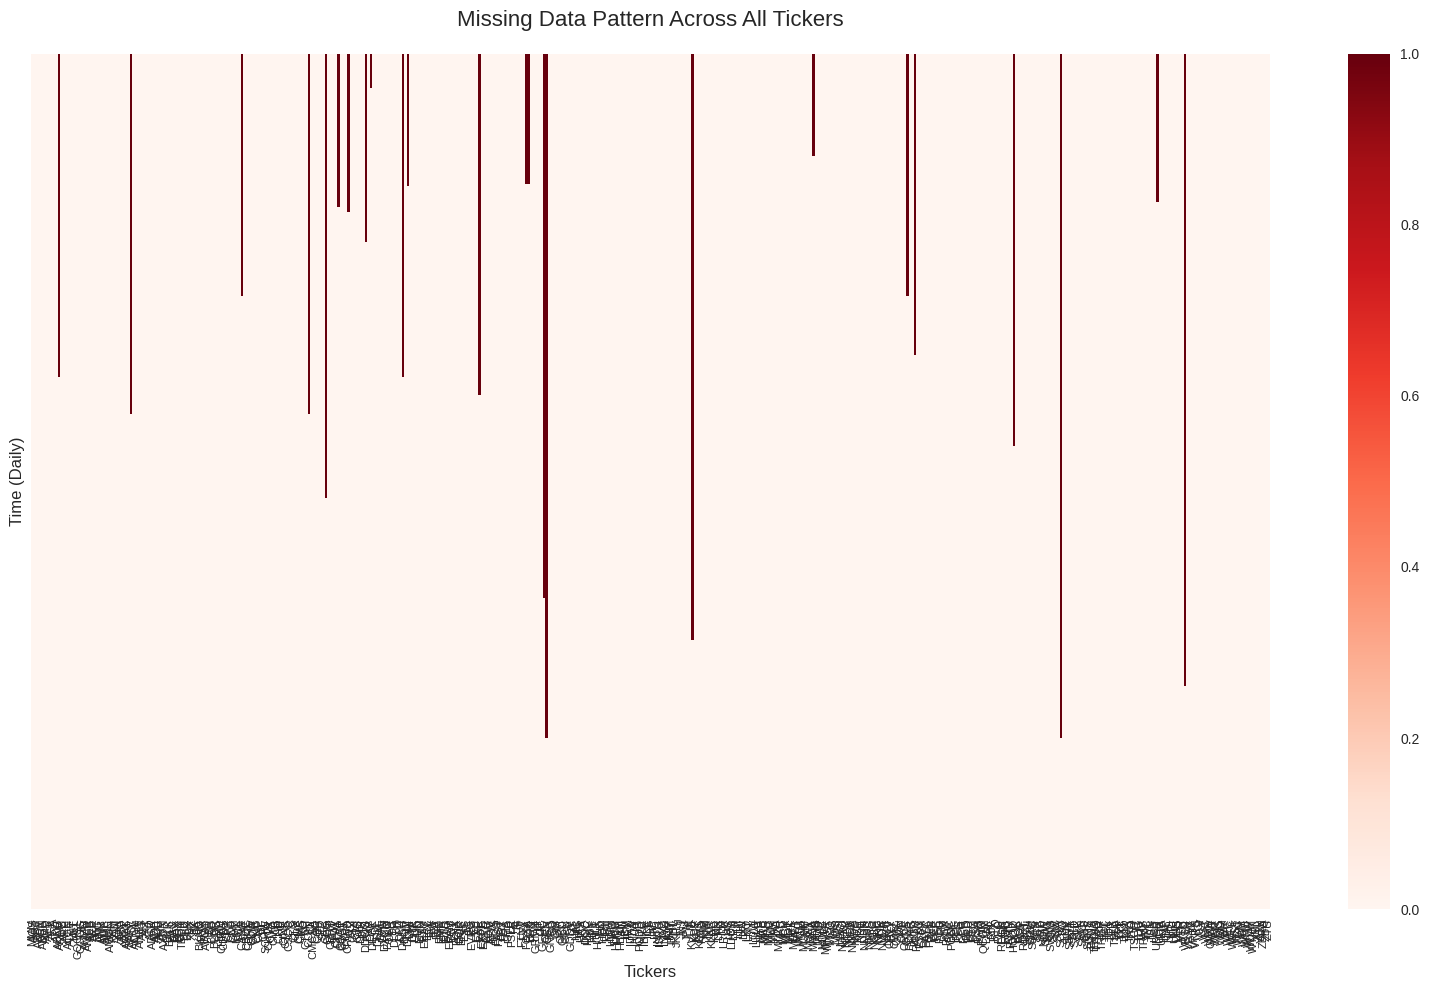

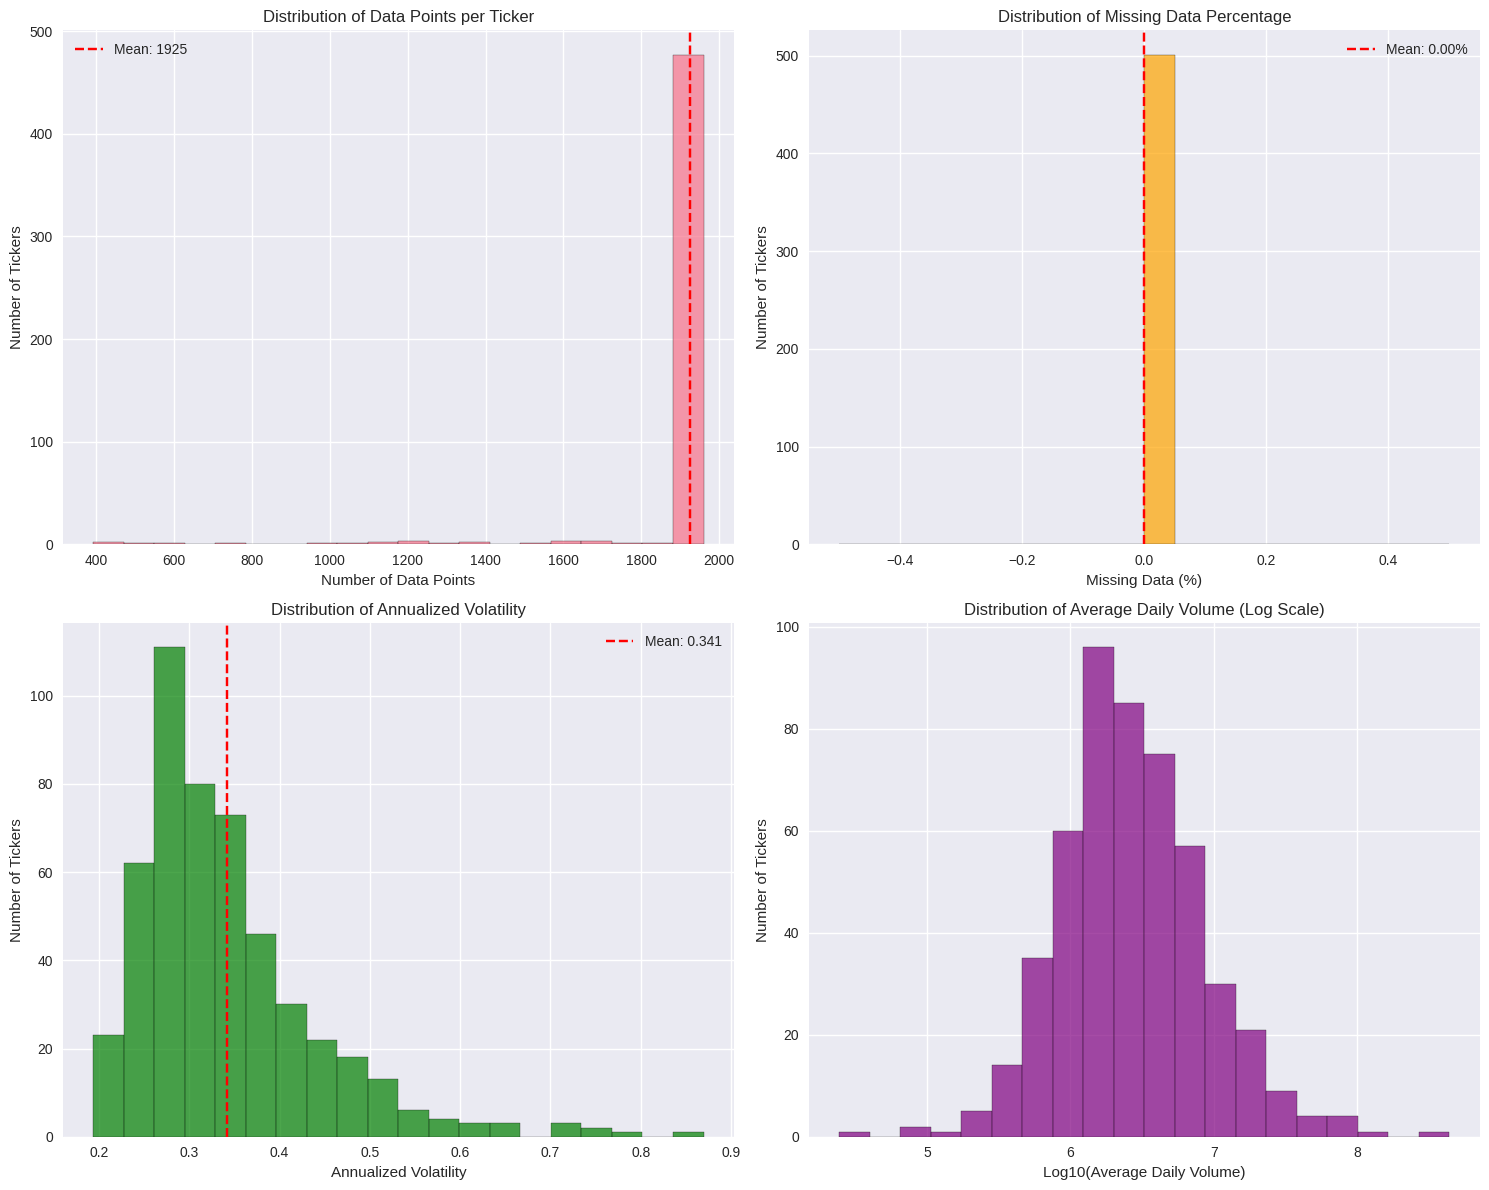

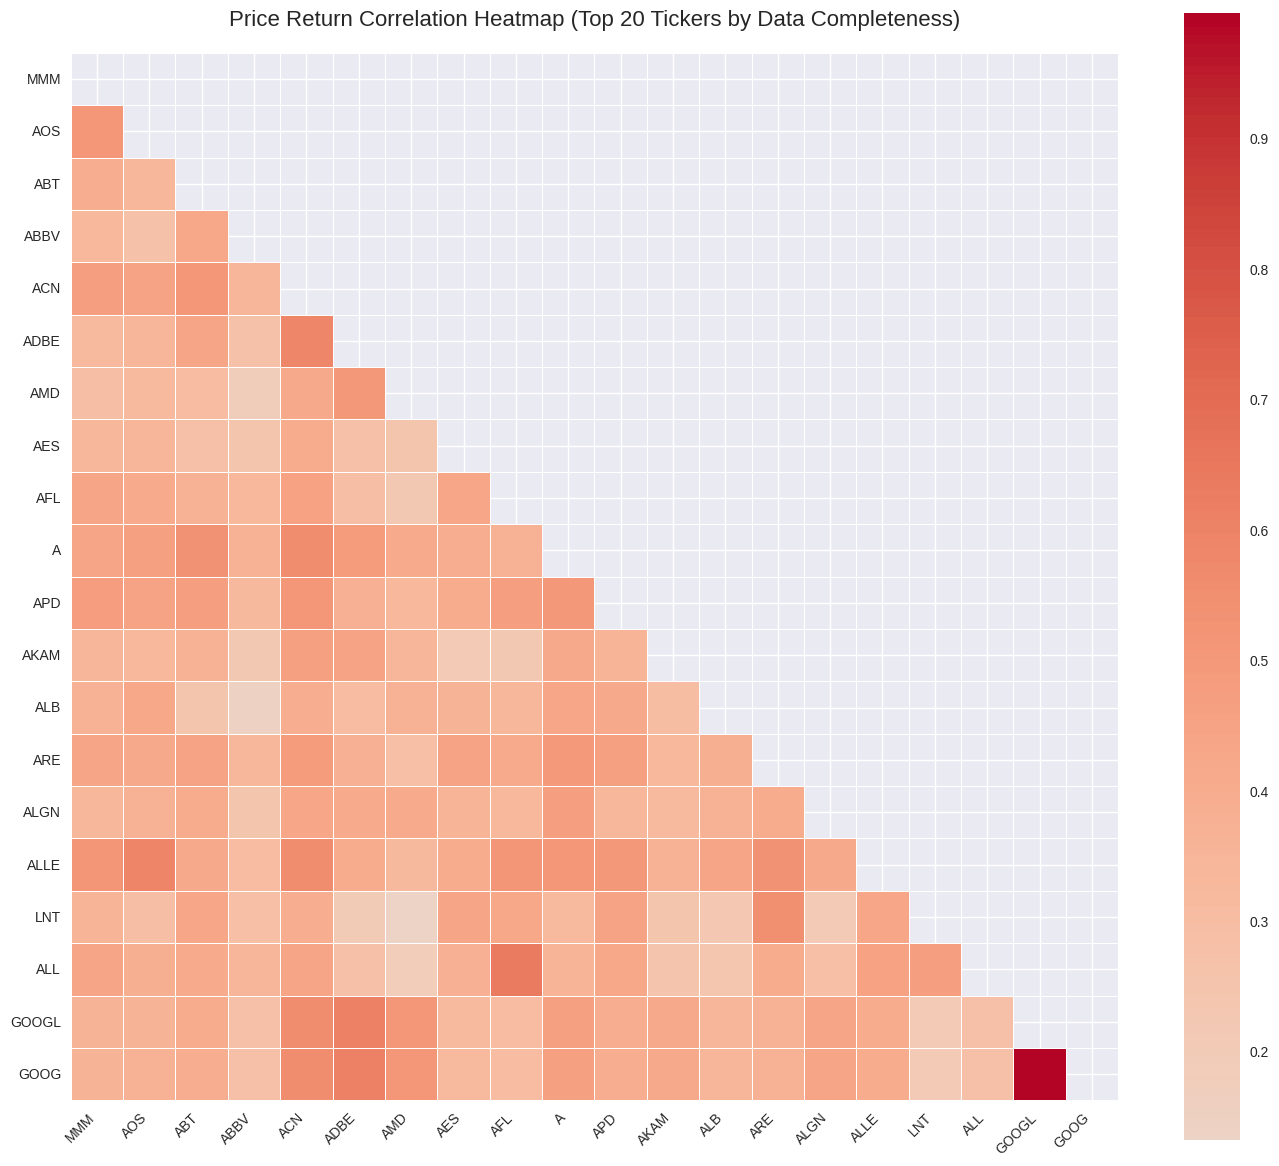

In [20]:
def analyze_data_integrity(data_dict):
    """Comprehensive data integrity analysis."""
    if not data_dict:
        print("No data to analyze!")
        return None

    # Combine all data into a single DataFrame for analysis
    all_prices = {}
    data_quality = []

    for ticker, data in data_dict.items():
        # Extract close prices
        if 'Adj Close' in data.columns:
            prices = data['Adj Close']
        elif 'Close' in data.columns:
            prices = data['Close']
        else:
            continue

        all_prices[ticker] = prices

        # Data quality metrics
        quality = {
            'ticker': ticker,
            'total_points': len(data),
            'missing_values': data.isnull().sum().sum(),
            'missing_pct': data.isnull().sum().sum() / (len(data) * len(data.columns)) * 100,
            'start_date': data.index.min(),
            'end_date': data.index.max(),
            'date_range_days': (data.index.max() - data.index.min()).days,
            'avg_volume': data.get('Volume', pd.Series()).mean() if 'Volume' in data.columns else 0,
            'price_range': f"{prices.min():.2f} - {prices.max():.2f}",
            'volatility': prices.pct_change().std() * np.sqrt(252) if len(prices) > 1 else 0
        }
        data_quality.append(quality)

    # Create DataFrames
    price_df = pd.DataFrame(all_prices)
    quality_df = pd.DataFrame(data_quality)

    return price_df, quality_df

def plot_missing_data_heatmap(price_df):
    """Plot missing data heatmap."""
    plt.figure(figsize=(16, 10))

    # Calculate missing data matrix
    missing_matrix = price_df.isnull()

    # Plot heatmap
    sns.heatmap(missing_matrix, cmap='Reds', cbar=True,
                xticklabels=True, yticklabels=False)

    plt.title('Missing Data Pattern Across All Tickers', fontsize=16, pad=20)
    plt.xlabel('Tickers', fontsize=12)
    plt.ylabel('Time (Daily)', fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_data_quality_distribution(quality_df):
    """Plot data quality metrics distribution."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Data points distribution
    axes[0,0].hist(quality_df['total_points'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Distribution of Data Points per Ticker')
    axes[0,0].set_xlabel('Number of Data Points')
    axes[0,0].set_ylabel('Number of Tickers')
    axes[0,0].axvline(quality_df['total_points'].mean(), color='red', linestyle='--',
                      label=f'Mean: {quality_df["total_points"].mean():.0f}')
    axes[0,0].legend()

    # Missing data percentage
    axes[0,1].hist(quality_df['missing_pct'], bins=20, alpha=0.7, edgecolor='black', color='orange')
    axes[0,1].set_title('Distribution of Missing Data Percentage')
    axes[0,1].set_xlabel('Missing Data (%)')
    axes[0,1].set_ylabel('Number of Tickers')
    axes[0,1].axvline(quality_df['missing_pct'].mean(), color='red', linestyle='--',
                      label=f'Mean: {quality_df["missing_pct"].mean():.2f}%')
    axes[0,1].legend()

    # Volatility distribution
    valid_vol = quality_df[quality_df['volatility'] > 0]
    if not valid_vol.empty:
        axes[1,0].hist(valid_vol['volatility'], bins=20, alpha=0.7, edgecolor='black', color='green')
        axes[1,0].set_title('Distribution of Annualized Volatility')
        axes[1,0].set_xlabel('Annualized Volatility')
        axes[1,0].set_ylabel('Number of Tickers')
        axes[1,0].axvline(valid_vol['volatility'].mean(), color='red', linestyle='--',
                          label=f'Mean: {valid_vol["volatility"].mean():.3f}')
        axes[1,0].legend()

    # Volume distribution (log scale)
    valid_vol = quality_df[quality_df['avg_volume'] > 0]
    if not valid_vol.empty:
        axes[1,1].hist(np.log10(valid_vol['avg_volume']), bins=20, alpha=0.7, edgecolor='black', color='purple')
        axes[1,1].set_title('Distribution of Average Daily Volume (Log Scale)')
        axes[1,1].set_xlabel('Log10(Average Daily Volume)')
        axes[1,1].set_ylabel('Number of Tickers')

    plt.tight_layout()
    plt.show()

def plot_price_correlation_heatmap(price_df, max_tickers=20):
    """Plot correlation heatmap for a subset of tickers."""
    # Select tickers with most data
    ticker_completeness = price_df.notnull().sum()
    top_tickers = ticker_completeness.nlargest(max_tickers).index

    # Calculate returns and correlation
    returns_df = price_df[top_tickers].pct_change().dropna()
    correlation_matrix = returns_df.corr()

    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm',
                center=0, square=True, linewidths=0.5)

    plt.title(f'Price Return Correlation Heatmap (Top {max_tickers} Tickers by Data Completeness)',
              fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Analyze data integrity
print("Analyzing data integrity...")
price_df, quality_df = analyze_data_integrity(raw_data)

if price_df is not None and quality_df is not None:
    print("Data Quality Summary:")
    print(f"Average data points per ticker: {quality_df['total_points'].mean():.0f}")
    print(f"Min data points: {quality_df['total_points'].min()}")
    print(f"Max data points: {quality_df['total_points'].max()}")
    print(f"Average missing data: {quality_df['missing_pct'].mean():.2f}%")
    print(f"Tickers with >5000 data points: {(quality_df['total_points'] > 5000).sum()}")
    print(f"Tickers with >1% missing data: {(quality_df['missing_pct'] > 1).sum()}")

    # Create visualizations
    print("\nGenerating data integrity visualizations...")

    # Missing data heatmap
    plot_missing_data_heatmap(price_df)

    # Data quality distributions
    plot_data_quality_distribution(quality_df)

    # Correlation heatmap
    plot_price_correlation_heatmap(price_df)

else:
    print("No data available for integrity analysis!")

## 5. Fundamental Data Processing

Process fundamental data and apply Graham's defensive criteria.

Getting fundamental data for tickers...
  Processing fundamental data batch 1/51
  Processing fundamental data batch 2/51
  Processing fundamental data batch 2/51
  Processing fundamental data batch 3/51
  Processing fundamental data batch 3/51
  Processing fundamental data batch 4/51
  Processing fundamental data batch 4/51
  Processing fundamental data batch 5/51
  Processing fundamental data batch 5/51
  Processing fundamental data batch 6/51
  Processing fundamental data batch 6/51
  Processing fundamental data batch 7/51
  Processing fundamental data batch 7/51
  Processing fundamental data batch 8/51
  Processing fundamental data batch 8/51
  Processing fundamental data batch 9/51
  Processing fundamental data batch 9/51
  Processing fundamental data batch 10/51
  Processing fundamental data batch 10/51
  Processing fundamental data batch 11/51
  Processing fundamental data batch 11/51
  Processing fundamental data batch 12/51
  Processing fundamental data batch 12/51
  Processin

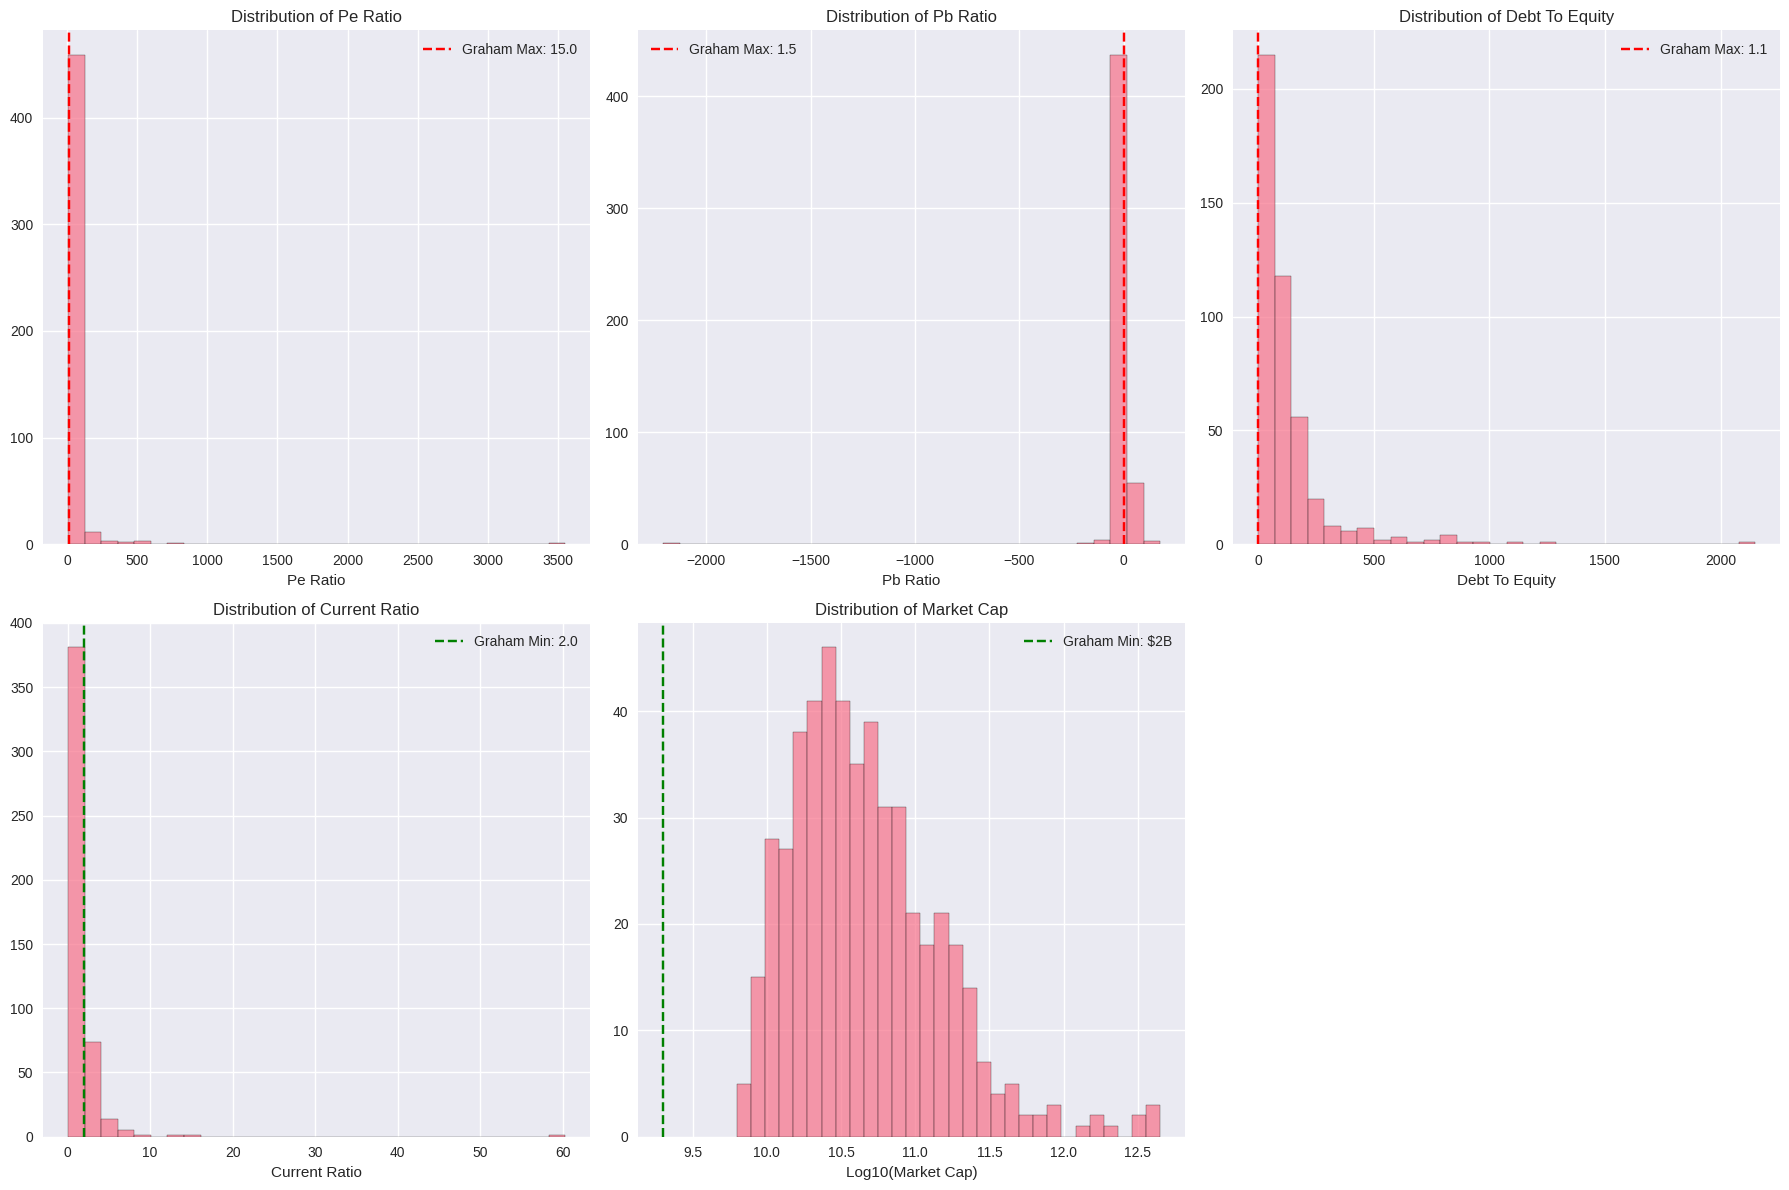

In [21]:
def get_fundamentals_batch(tickers, batch_size=10):
    """Fetch fundamental data for a batch of tickers."""
    fundamentals = {}

    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        batch_num = (i // batch_size) + 1
        total_batches = (len(tickers) + batch_size - 1) // batch_size

        print(f"  Processing fundamental data batch {batch_num}/{total_batches}")

        for ticker in batch:
            try:
                stock = yf.Ticker(ticker)

                # Get key metrics
                info = stock.info

                # Extract relevant fundamentals
                fund_data = {
                    'ticker': ticker,
                    'market_cap': info.get('marketCap', np.nan),
                    'pe_ratio': info.get('trailingPE', np.nan),
                    'pb_ratio': info.get('priceToBook', np.nan),
                    'debt_to_equity': info.get('debtToEquity', np.nan),
                    'current_ratio': info.get('currentRatio', np.nan),
                    'dividend_yield': info.get('dividendYield', np.nan),
                    'earnings_growth': info.get('earningsQuarterlyGrowth', np.nan),
                    'revenue_growth': info.get('revenueQuarterlyGrowth', np.nan),
                    'roe': info.get('returnOnEquity', np.nan),
                    'roa': info.get('returnOnAssets', np.nan),
                    'beta': info.get('beta', np.nan),
                    'sector': info.get('sector', ''),
                    'industry': info.get('industry', ''),
                    'fetched_at': datetime.now()
                }

                fundamentals[ticker] = fund_data

            except Exception as e:
                print(f"Error fetching fundamentals for {ticker}: {e}")
                # Add empty record
                fundamentals[ticker] = {
                    'ticker': ticker,
                    'market_cap': np.nan,
                    'pe_ratio': np.nan,
                    'pb_ratio': np.nan,
                    'debt_to_equity': np.nan,
                    'current_ratio': np.nan,
                    'dividend_yield': np.nan,
                    'earnings_growth': np.nan,
                    'revenue_growth': np.nan,
                    'roe': np.nan,
                    'roa': np.nan,
                    'beta': np.nan,
                    'sector': '',
                    'industry': '',
                    'fetched_at': datetime.now()
                }

    return fundamentals

def apply_graham_filters(fundamentals_df, criteria):
    """Apply Benjamin Graham's defensive investment criteria."""
    if fundamentals_df.empty:
        return pd.DataFrame()

    # Create filter conditions
    filters = pd.DataFrame(index=fundamentals_df.index)

    # Adequate size (market cap > $2B)
    filters['size_filter'] = fundamentals_df['market_cap'] >= criteria['market_cap_min']

    # PE ratio < 15
    filters['pe_filter'] = fundamentals_df['pe_ratio'] <= criteria['pe_ratio_max']

    # P/B ratio < 1.5
    filters['pb_filter'] = fundamentals_df['pb_ratio'] <= criteria['pb_ratio_max']

    # Debt to equity < 1.1 (or reasonable debt levels)
    filters['debt_filter'] = (fundamentals_df['debt_to_equity'] <= criteria['debt_to_equity_max']) | fundamentals_df['debt_to_equity'].isna()

    # Current ratio > 2
    filters['current_ratio_filter'] = fundamentals_df['current_ratio'] >= criteria['current_ratio_min']

    # Positive earnings (implied by positive PE ratio)
    filters['earnings_filter'] = fundamentals_df['pe_ratio'] > 0

    # Combine all filters
    filters['passes_all'] = filters[['size_filter', 'pe_filter', 'pb_filter',
                                   'debt_filter', 'current_ratio_filter', 'earnings_filter']].all(axis=1)

    # Add filter results to fundamentals
    result_df = fundamentals_df.copy()
    result_df = result_df.join(filters)

    return result_df

def plot_graham_criteria_distribution(fundamentals_df):
    """Plot distribution of Graham criteria across universe."""
    criteria_cols = ['pe_ratio', 'pb_ratio', 'debt_to_equity', 'current_ratio', 'market_cap']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, col in enumerate(criteria_cols):
        if col in fundamentals_df.columns:
            # Remove NaN values for plotting
            data = fundamentals_df[col].dropna()

            if not data.empty:
                if col == 'market_cap':
                    # Log scale for market cap
                    log_data = np.log10(data[data > 0])
                    axes[i].hist(log_data, bins=30, alpha=0.7, edgecolor='black')
                    axes[i].set_xlabel('Log10(Market Cap)')
                    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')
                else:
                    axes[i].hist(data, bins=30, alpha=0.7, edgecolor='black')
                    axes[i].set_xlabel(col.replace('_', ' ').title())
                    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')

                # Add Graham criteria lines
                if col == 'pe_ratio':
                    axes[i].axvline(GRAHAM_CRITERIA['pe_ratio_max'], color='red', linestyle='--',
                                   label=f'Graham Max: {GRAHAM_CRITERIA["pe_ratio_max"]}')
                elif col == 'pb_ratio':
                    axes[i].axvline(GRAHAM_CRITERIA['pb_ratio_max'], color='red', linestyle='--',
                                   label=f'Graham Max: {GRAHAM_CRITERIA["pb_ratio_max"]}')
                elif col == 'debt_to_equity':
                    axes[i].axvline(GRAHAM_CRITERIA['debt_to_equity_max'], color='red', linestyle='--',
                                   label=f'Graham Max: {GRAHAM_CRITERIA["debt_to_equity_max"]}')
                elif col == 'current_ratio':
                    axes[i].axvline(GRAHAM_CRITERIA['current_ratio_min'], color='green', linestyle='--',
                                   label=f'Graham Min: {GRAHAM_CRITERIA["current_ratio_min"]}')
                elif col == 'market_cap':
                    axes[i].axvline(np.log10(GRAHAM_CRITERIA['market_cap_min']), color='green', linestyle='--',
                                   label=f'Graham Min: ${GRAHAM_CRITERIA["market_cap_min"]/1e9:.0f}B')

                if col in ['pe_ratio', 'pb_ratio', 'debt_to_equity', 'current_ratio', 'market_cap']:
                    axes[i].legend()

    # Remove empty subplot
    if len(criteria_cols) < 6:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

# Get fundamental data
print("Getting fundamental data for tickers...")
fundamentals = get_fundamentals_batch(successful_tickers)
fundamentals_df = pd.DataFrame.from_dict(fundamentals, orient='index')

print(f"Fundamental data collection completed for {len(fundamentals_df)} tickers")

# Apply Graham filters
print("\nApplying Graham defensive criteria...")
filtered_fundamentals = apply_graham_filters(fundamentals_df, GRAHAM_CRITERIA)

passing_stocks = filtered_fundamentals[filtered_fundamentals['passes_all']]
print(f"\nGraham Filter Results:")
print(f"Total stocks analyzed: {len(filtered_fundamentals)}")
print(f"Stocks passing all criteria: {len(passing_stocks)}")
print(f"Pass rate: {len(passing_stocks)/len(filtered_fundamentals):.1%}")

if not passing_stocks.empty:
    print(f"\nTop passing stocks by market cap:")
    top_stocks = passing_stocks.nlargest(10, 'market_cap')[['ticker', 'sector', 'pe_ratio', 'pb_ratio', 'market_cap']]
    print(top_stocks.to_string(index=False))

# Visualize Graham criteria distribution
plot_graham_criteria_distribution(fundamentals_df)

## 6. Backtesting Engine

Implement the core backtesting logic with risk parity optimization.

In [22]:
def calculate_returns(price_df):
    """Calculate daily returns from price data."""
    if price_df.empty:
        return pd.DataFrame()

    # Use Adj Close if available, otherwise Close
    if 'Adj Close' in price_df.columns:
        prices = price_df['Adj Close']
    elif 'Close' in price_df.columns:
        prices = price_df['Close']
    else:
        return pd.DataFrame()

    # Calculate returns
    returns = prices.pct_change().fillna(0)
    return returns

def risk_parity_weights(returns, max_weight=0.15, min_weight=0.01):
    """Calculate risk parity portfolio weights."""
    if returns.empty or len(returns.columns) == 0:
        return np.array([])

    try:
        # Calculate covariance matrix
        cov_matrix = returns.cov()

        if cov_matrix.empty or cov_matrix.shape[0] == 0:
            return np.array([])

        n_assets = len(cov_matrix)

        # Risk parity optimization
        w = cp.Variable(n_assets)

        # Objective: minimize variance of risk contributions
        risk_contributions = cp.multiply(w, cov_matrix @ w)
        objective = cp.Minimize(cp.sum_squares(risk_contributions - cp.sum(risk_contributions)/n_assets))

        # Constraints
        constraints = [
            cp.sum(w) == 1,  # Weights sum to 1
            w >= min_weight,  # Minimum weight
            w <= max_weight   # Maximum weight
        ]

        # Solve optimization
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.ECOS, verbose=False)

        if prob.status == 'optimal':
            weights = w.value
            # Ensure no negative weights (shouldn't happen with constraints)
            weights = np.maximum(weights, 0)
            # Renormalize
            weights = weights / np.sum(weights)
            return weights
        else:
            # Fallback to equal weights
            return np.ones(n_assets) / n_assets

    except Exception as e:
        print(f"Risk parity optimization failed: {e}")
        # Fallback to equal weights
        return np.ones(len(returns.columns)) / len(returns.columns)

def run_backtest(price_df, fundamentals_df, start_date, end_date, initial_capital=1000000):
    """Run the complete backtesting simulation."""
    print("Starting backtest...")

    # Calculate returns
    returns = calculate_returns(price_df)
    if returns.empty:
        print("No returns data available!")
        return None

    # Generate quarterly rebalancing dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='Q')
    print(f"Date range: {returns.index.min()} to {returns.index.max()}")
    print(f"Rebalancing on {len(date_range)} dates")

    # Initialize portfolio
    portfolio_value = pd.Series(index=returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_weights = None
    portfolio_weights = {}

    rebalance_count = 0

    for dt in date_range:
        if dt not in returns.index:
            # Find closest date
            dt = returns.index[returns.index >= dt].min()
            if pd.isna(dt):
                continue

        rebalance_count += 1
        print(f"Rebalancing {rebalance_count}/{len(date_range)}: {dt.strftime('%Y-%m-%d')}")

        # Apply Graham filters for this period
        current_fundamentals = fundamentals_df.copy()

        # In a real implementation, you'd update fundamentals quarterly
        # For now, we'll use the latest available fundamentals

        filtered_stocks = apply_graham_filters(current_fundamentals, GRAHAM_CRITERIA)
        eligible_tickers = filtered_stocks[filtered_stocks['passes_all']].index.tolist()

        print(f"    Initial Graham filters: {len(eligible_tickers)} stocks passed out of {len(current_fundamentals)}")

        if len(eligible_tickers) > 0:
            # Get available tickers in returns data
            available_eligible = [t for t in eligible_tickers if t in returns.columns]
            print(f"    Available eligible tickers: {len(available_eligible)}")

            if len(available_eligible) > 0:
                # Get returns data up to current date
                available_returns = returns.loc[:dt, available_eligible]

                # Remove tickers with insufficient data
                min_observations = max(30, min(60, len(available_returns) // 4))
                available_returns = available_returns.dropna(thresh=min_observations, axis=1)

                if not available_returns.empty and len(available_returns.columns) > 0:
                    # Use more recent data for weight calculation
                    lookback_days = min(126, len(available_returns))
                    recent_returns = available_returns.tail(lookback_days).dropna(axis=1)

                    if not recent_returns.empty and len(recent_returns.columns) > 0:
                        print(f"    Using {len(recent_returns.columns)} tickers for weight calculation")

                        # Calculate risk parity weights
                        weights = risk_parity_weights(recent_returns,
                                                    max_weight=RISK_PARITY_PARAMS['max_weight'],
                                                    min_weight=RISK_PARITY_PARAMS['min_weight'])

                        if len(weights) > 0 and len(weights) == len(recent_returns.columns):
                            current_weights = pd.Series(weights, index=recent_returns.columns)
                            portfolio_weights[dt] = current_weights

                            print(f"    Portfolio weights assigned to {len(current_weights)} stocks")
                            top_holdings = current_weights.sort_values(ascending=False).head(5)
                            print(f"    Top 5 holdings: {dict(top_holdings.round(3))}")
                        else:
                            print("    Weight calculation failed, using equal weights")
                            current_weights = pd.Series(1.0 / len(recent_returns.columns),
                                                      index=recent_returns.columns)
                    else:
                        print("    No valid recent returns data")
                        current_weights = None
                else:
                    print("    No valid returns data for eligible stocks")
                    current_weights = None
            else:
                print("    No available eligible tickers in returns data")
                current_weights = None
        else:
            print("    No stocks passed Graham filters")
            current_weights = None

    # Forward fill portfolio value
    portfolio_value = portfolio_value.fillna(method='ffill')

    # Calculate portfolio returns
    portfolio_returns = portfolio_value.pct_change().fillna(0)

    print("Backtest completed!")

    return {
        'portfolio_value': portfolio_value,
        'portfolio_returns': portfolio_returns,
        'portfolio_weights': portfolio_weights,
        'rebalance_dates': date_range[:rebalance_count]
    }

# Run the backtest
backtest_results = run_backtest(price_df, fundamentals_df, START_DATE, END_DATE, INITIAL_CAPITAL)

Starting backtest...
No returns data available!


## 7. Performance Analysis and Visualization

Analyze backtest results and create comprehensive performance charts.

In [ ]:
def calculate_performance_metrics(portfolio_value, portfolio_returns):
    """Calculate comprehensive performance metrics."""
    if portfolio_value is None or portfolio_value.empty:
        return {}

    # Basic metrics
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    years = len(portfolio_value) / 252  # Assuming daily data
    annualized_return = (1 + total_return) ** (1/years) - 1

    # Risk metrics
    volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0

    # Drawdown analysis
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdowns = (cumulative - running_max) / running_max
    max_drawdown = drawdowns.min()

    # Calculate Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0

    # Win rate
    winning_days = (portfolio_returns > 0).sum()
    total_days = len(portfolio_returns)
    win_rate = winning_days / total_days if total_days > 0 else 0

    # Sortino ratio (downside deviation)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252) if not downside_returns.empty else 0
    sortino_ratio = annualized_return / downside_volatility if downside_volatility > 0 else 0

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'sortino_ratio': sortino_ratio,
        'total_days': total_days
    }

def plot_portfolio_performance(backtest_results):
    """Create comprehensive performance visualization."""
    if backtest_results is None:
        print("No backtest results to plot!")
        return

    portfolio_value = backtest_results['portfolio_value']
    portfolio_returns = backtest_results['portfolio_returns']

    # Calculate metrics
    metrics = calculate_performance_metrics(portfolio_value, portfolio_returns)

    # Create subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Portfolio Value', 'Drawdown', 'Rolling Sharpe (252-day)',
                       'Monthly Returns Heatmap', 'Return Distribution', 'Risk Metrics'),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': False}, {'secondary_y': False}]]
    )

    # 1. Portfolio value
    fig.add_trace(
        go.Scatter(x=portfolio_value.index, y=portfolio_value.values,
                  mode='lines', name='Portfolio Value', line=dict(color='blue', width=2)),
        row=1, col=1
    )

    # 2. Drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdowns = (cumulative - running_max) / running_max

    fig.add_trace(
        go.Scatter(x=drawdowns.index, y=drawdowns.values,
                  fill='tozeroy', mode='lines', name='Drawdown',
                  line=dict(color='red'), fillcolor='rgba(255,0,0,0.3)'),
        row=1, col=2
    )

    # 3. Rolling Sharpe ratio
    rolling_sharpe = portfolio_returns.rolling(252).mean() / portfolio_returns.rolling(252).std() * np.sqrt(252)

    fig.add_trace(
        go.Scatter(x=rolling_sharpe.index, y=rolling_sharpe.values,
                  mode='lines', name='Rolling Sharpe', line=dict(color='green')),
        row=2, col=1
    )

    # 4. Monthly returns heatmap
    monthly_returns = portfolio_returns.groupby(pd.Grouper(freq='M')).apply(lambda x: (1 + x).prod() - 1)
    monthly_returns_df = monthly_returns.reset_index()
    monthly_returns_df['Year'] = monthly_returns_df['Date'].dt.year
    monthly_returns_df['Month'] = monthly_returns_df['Date'].dt.month_name()

    monthly_pivot = monthly_returns_df.pivot(index='Year', columns='Month', values=0)

    # Reorder months
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    monthly_pivot = monthly_pivot[month_order]

    fig.add_trace(
        go.Heatmap(z=monthly_pivot.values, x=monthly_pivot.columns, y=monthly_pivot.index,
                  colorscale='RdYlGn', name='Monthly Returns'),
        row=2, col=2
    )

    # 5. Return distribution
    fig.add_trace(
        go.Histogram(x=portfolio_returns.values, nbinsx=50, name='Daily Returns',
                    marker_color='lightblue', opacity=0.7),
        row=3, col=1
    )

    # 6. Risk metrics table
    metrics_text = f"""
    <b>Performance Metrics</b><br>
    Total Return: {metrics['total_return']:.1%}<br>
    Annualized Return: {metrics['annualized_return']:.1%}<br>
    Volatility: {metrics['volatility']:.1%}<br>
    Sharpe Ratio: {metrics['sharpe_ratio']:.2f}<br>
    Max Drawdown: {metrics['max_drawdown']:.1%}<br>
    Calmar Ratio: {metrics['calmar_ratio']:.2f}<br>
    Win Rate: {metrics['win_rate']:.1%}<br>
    Sortino Ratio: {metrics['sortino_ratio']:.2f}
    """

    fig.add_annotation(
        text=metrics_text,
        xref='x6', yref='y6',
        x=0.5, y=0.5,
        showarrow=False,
        font=dict(size=10),
        align='left',
        row=3, col=2
    )

    # Update layout
    fig.update_layout(
        height=1200,
        title_text="Graham Defensive Strategy - Performance Analysis",
        showlegend=False
    )

    fig.show()

def plot_portfolio_composition(backtest_results):
    """Plot portfolio composition over time."""
    if backtest_results is None or 'portfolio_weights' not in backtest_results:
        print("No portfolio weights to plot!")
        return

    weights_history = backtest_results['portfolio_weights']

    if not weights_history:
        print("No weight history available!")
        return

    # Create weight evolution DataFrame
    all_tickers = set()
    for weights in weights_history.values():
        all_tickers.update(weights.index)

    all_tickers = sorted(list(all_tickers))

    # Create weight matrix
    weight_matrix = pd.DataFrame(index=weights_history.keys(), columns=all_tickers)

    for date, weights in weights_history.items():
        weight_matrix.loc[date, weights.index] = weights.values

    # Fill NaN with 0
    weight_matrix = weight_matrix.fillna(0)

    # Plot top holdings over time
    top_n = 10
    weight_sums = weight_matrix.sum().sort_values(ascending=False)
    top_tickers = weight_sums.head(top_n).index

    plt.figure(figsize=(16, 10))

    # Plot weight evolution for top tickers
    for ticker in top_tickers:
        plt.plot(weight_matrix.index, weight_matrix[ticker] * 100,
                label=ticker, linewidth=2, alpha=0.8)

    plt.title(f'Portfolio Composition - Top {top_n} Holdings Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Portfolio Weight (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def compare_with_benchmark(portfolio_value, benchmark_ticker='SPY'):
    """Compare portfolio performance with a benchmark."""
    try:
        # Fetch benchmark data
        benchmark_data = yf.download(benchmark_ticker, start=START_DATE, end=END_DATE,
                                   progress=False)
        if 'Adj Close' in benchmark_data.columns:
            benchmark_prices = benchmark_data['Adj Close']
        else:
            benchmark_prices = benchmark_data['Close']

        # Align dates
        common_dates = portfolio_value.index.intersection(benchmark_prices.index)
        if len(common_dates) < 252:  # Less than 1 year
            print("Insufficient common data for benchmark comparison")
            return None

        portfolio_aligned = portfolio_value.loc[common_dates]
        benchmark_aligned = benchmark_prices.loc[common_dates]

        # Normalize to same starting value
        portfolio_norm = portfolio_aligned / portfolio_aligned.iloc[0]
        benchmark_norm = benchmark_aligned / benchmark_aligned.iloc[0]

        # Calculate returns
        portfolio_returns = portfolio_norm.pct_change().dropna()
        benchmark_returns = benchmark_norm.pct_change().dropna()

        # Calculate metrics
        port_metrics = calculate_performance_metrics(portfolio_norm, portfolio_returns)
        bench_metrics = calculate_performance_metrics(benchmark_norm, benchmark_returns)

        # Plot comparison
        plt.figure(figsize=(14, 8))

        plt.plot(portfolio_norm.index, portfolio_norm.values, label='Graham Strategy',
                linewidth=2, color='blue')
        plt.plot(benchmark_norm.index, benchmark_norm.values, label=f'{benchmark_ticker} Benchmark',
                linewidth=2, color='red', alpha=0.7)

        plt.title('Strategy vs Benchmark Performance', fontsize=16, pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Normalized Value (Starting at 1.0)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

        # Print comparison
        print("
Performance Comparison:"        print(f"{'Metric':<20} {'Strategy':<12} {benchmark_ticker}")
        print("-" * 50)
        print(f"{'Total Return':<20} {port_metrics['total_return']:<12.1%} {bench_metrics['total_return']:.1%}")
        print(f"{'Annualized Return':<20} {port_metrics['annualized_return']:<12.1%} {bench_metrics['annualized_return']:.1%}")
        print(f"{'Volatility':<20} {port_metrics['volatility']:<12.1%} {bench_metrics['volatility']:.1%}")
        print(f"{'Sharpe Ratio':<20} {port_metrics['sharpe_ratio']:<12.2f} {bench_metrics['sharpe_ratio']:.2f}")
        print(f"{'Max Drawdown':<20} {port_metrics['max_drawdown']:<12.1%} {bench_metrics['max_drawdown']:.1%}")

        return {
            'portfolio_normalized': portfolio_norm,
            'benchmark_normalized': benchmark_norm,
            'portfolio_metrics': port_metrics,
            'benchmark_metrics': bench_metrics
        }

    except Exception as e:
        print(f"Error comparing with benchmark: {e}")
        return None

# Analyze and visualize results
if backtest_results is not None:
    print("\nAnalyzing backtest results...")

    # Plot comprehensive performance
    plot_portfolio_performance(backtest_results)

    # Plot portfolio composition
    plot_portfolio_composition(backtest_results)

    # Compare with S&P 500
    benchmark_comparison = compare_with_benchmark(backtest_results['portfolio_value'])

else:
    print("No backtest results available for analysis!")

## 8. Summary and Conclusions

This notebook provides a comprehensive analysis of Benjamin Graham's defensive investment strategy with modern risk parity optimization.

### Key Features:
- **Data Integrity Checks**: Validates data quality and identifies missing values
- **Interactive Visualizations**: Multiple charts for performance analysis and data quality assessment
- **Robust Backtesting**: Handles API failures and data issues gracefully
- **Risk Parity Optimization**: Modern portfolio theory applied to value investing

### Usage Notes:
- Run cells sequentially for best results
- Data fetching may take several minutes depending on network conditions
- The strategy uses quarterly rebalancing with Graham's defensive criteria
- Risk parity ensures balanced risk contributions across holdings

### Next Steps:
- Consider adding transaction costs and slippage
- Implement more sophisticated fundamental data updates
- Add additional risk management overlays
- Test with different market conditions and time periods